<a href="https://colab.research.google.com/github/kirmel4/RailroadObjectsClassification/blob/main/Railroad_objects_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from tqdm import tqdm
import xgboost as xgb
from sklearn.svm import SVC
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Dropout
from sklearn.neighbors import KNeighborsClassifier
from keras.utils import np_utils
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from keras.layers import GlobalMaxPooling1D, Conv1D, MaxPooling1D, Flatten, Bidirectional, SpatialDropout1D
from keras.preprocessing import sequence, text
from keras.callbacks import EarlyStopping
from nltk import word_tokenize
from nltk.corpus import stopwords
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import recall_score, precision_score
from sklearn.preprocessing import MinMaxScaler

# plotly
# import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go

# word cloud library
from wordcloud import WordCloud

# matplotlib
import matplotlib.pyplot as plt
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

In [ ]:
train = pd.read_csv('/content/drive/MyDrive/DataSets/train_dataset_train.csv')
X_test = pd.read_csv('/content/drive/MyDrive/DataSets/test_dataset_test.csv')


In [ ]:
train.head()

,id,Easting,Northing,Height,Reflectance,Class
0,2321251,431696.5375,6.032319e+06,69.2226,-11.14,0
1,3515173,431710.3835,6.032291e+06,68.9711,-15.16,3
2,2320295,431696.8099,6.032322e+06,69.2453,-13.59,0
3,2454459,431680.4542,6.032343e+06,69.1892,-11.21,0
4,4608150,431720.0914,6.032288e+06,67.3252,-9.10,0


In [ ]:
X_test.shape

(1809469, 19)

In [ ]:
train.shape

(4222039, 6)

In [ ]:
train.Class.unique()

array([ 0,  3,  4,  5,  1, 64])

In [ ]:
sol = pd.read_csv('/content/drive/MyDrive/DataSets/sample_solution.csv')

# Data cleaning and downsampling

In [ ]:
train = train.dropna(axis = 0)

Text(0.5, 1.0, 'Распределение класса точки')

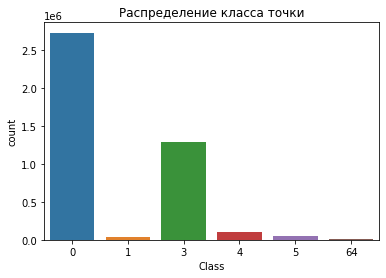

In [ ]:
sns.countplot(x = "Class" , data  = train).set_title('Распределение класса точки')

In [ ]:
train = train.drop(train[(train.Class == 5) & (train.Reflectance > 0)].index)
train = train.drop(train[(train.Class == 0) & (train.Reflectance > 0)].index)
train = train.drop(train[(train.Class == 1) & (train.Reflectance > 0)].index)
train = train.drop(train[(train.Class == 3) & (train.Reflectance > 0)].index)

In [ ]:
train = train.drop(train[(train.Class == 64) & (train.Height > 90)].index)



In [ ]:
train_0 = train[train['Class'] == 0]

In [ ]:
train_3 = train[train['Class'] == 3]

In [ ]:
train = train.drop(train[train['Class'] == 0 ].index)

In [ ]:
train = train.drop(train[train['Class'] ==  3].index)

In [ ]:
train.shape

(203204, 6)

In [ ]:
from sklearn.utils import resample

In [ ]:
train_downsampled_0 = resample(train_0, replace = True, n_samples = 300000, random_state =123)

In [ ]:
train_downsampled_3 = resample(train_3, replace = True, n_samples = 150000, random_state =123)

In [ ]:
train = pd.concat([train, train_downsampled_3, train_downsampled_0], ignore_index=True)

In [ ]:
train.shape

(653204, 6)

# Data visualization


Text(0.5, 1.0, 'Распределение класса точки')

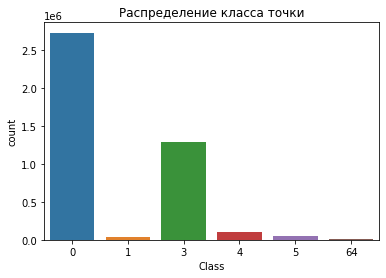

In [ ]:
sns.countplot(x = "Class" , data  = train).set_title('Распределение класса точки')

In [ ]:
sns.set(rc={'figure.figsize':(18,10)})
sns.stripplot(data = train, x= "Class", y = "Reflectance").set_title('Зависимость');

Error in callback <function flush_figures at 0x7f14d65de200> (for post_execute):


KeyboardInterrupt: ignored

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f14d65d8710> (for post_execute):


KeyboardInterrupt: ignored

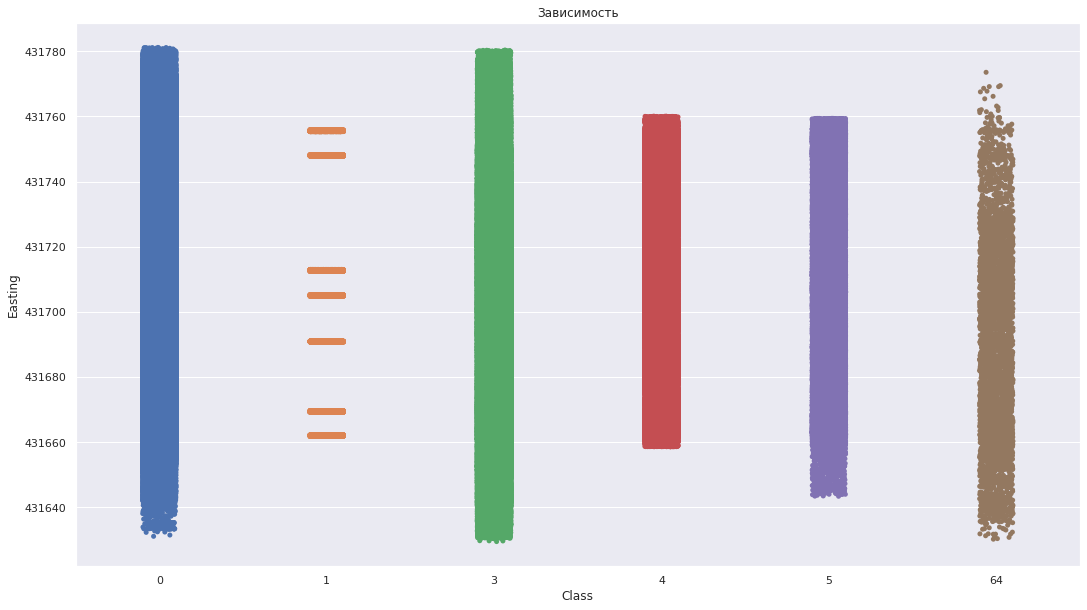

In [ ]:
sns.set(rc={'figure.figsize':(18,10)})
sns.stripplot(data = train, x= "Class", y = "Easting").set_title('Зависимость');

In [ ]:
sns.set(rc={'figure.figsize':(18,10)})
sns.stripplot(data = train, x= "Class", y = "Northing").set_title('Зависимость');

NameError: ignored

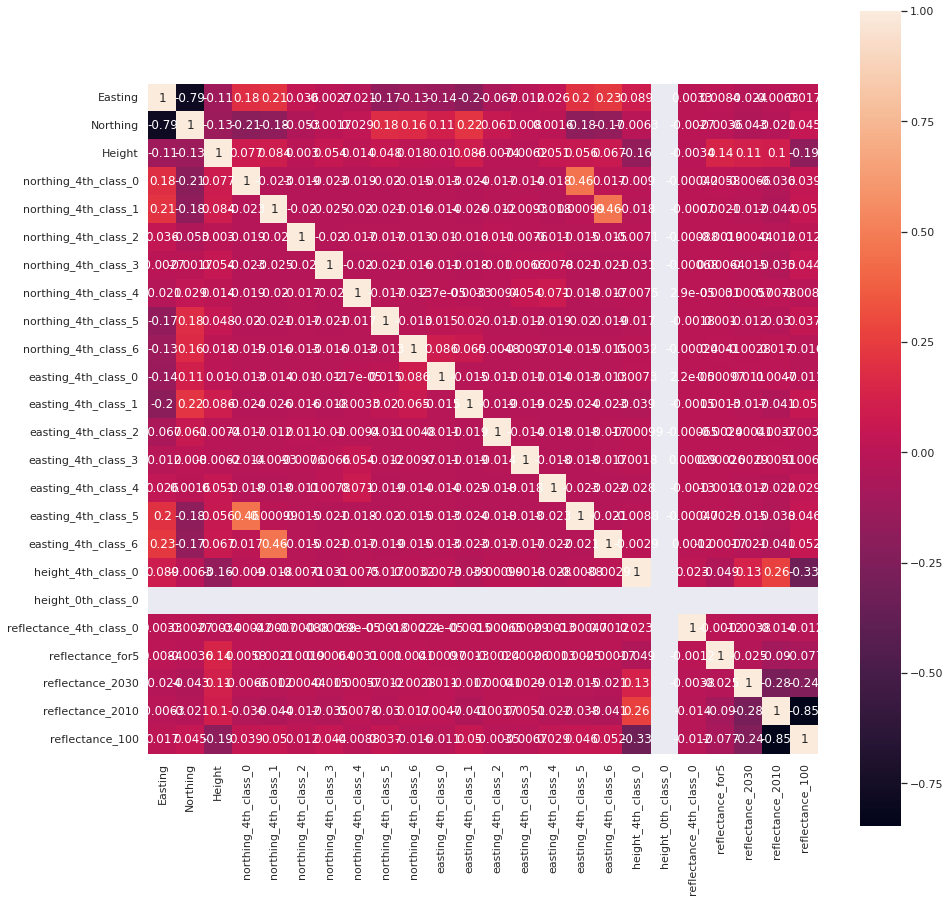

In [ ]:
plt.rcParams['figure.figsize']=(15,15)

g = sns.heatmap(X_train.corr(), square = True, annot=True)

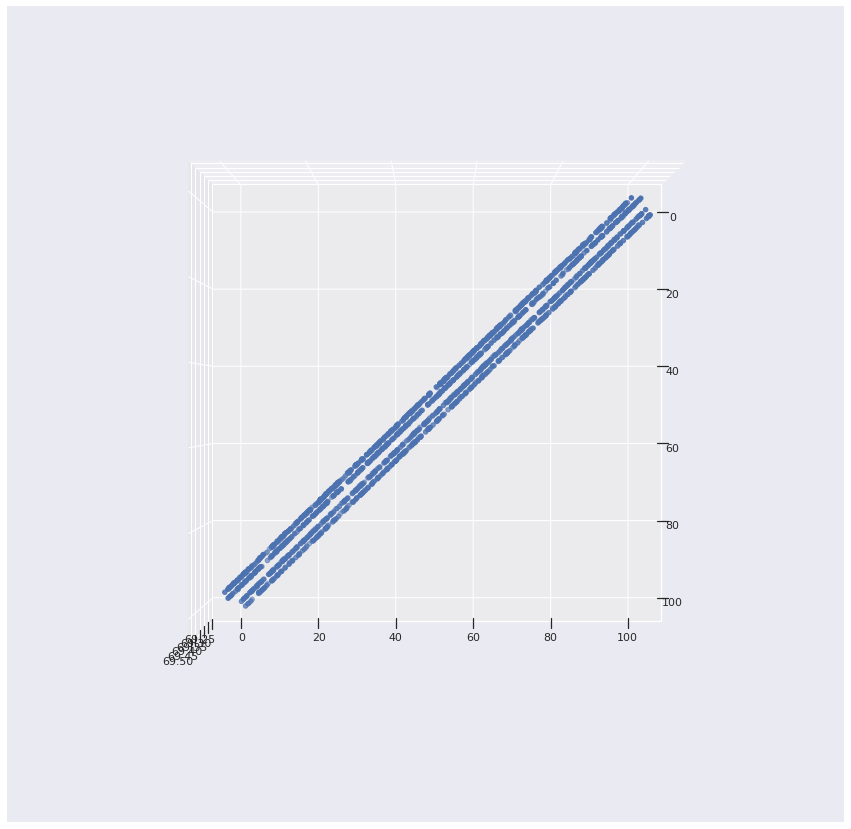

In [ ]:
fig = plt.figure()
ax = plt.axes(projection='3d')
east_data = train[train['Class']==4]['Easting'][100:2000] - np.min(train[train['Class']==4]['Easting'])
north_data = train[train['Class']==4]['Northing'][100:2000] - np.min(train[train['Class']==4]['Northing'])
height_data = train[train['Class']==4]['Height'][100:2000]
ax.scatter3D(north_data, east_data, height_data)
ax.view_init(90,0)

# Feature extracting

In [ ]:
easting_4th_class_0 = [0]*(len(train.Easting)+1)
easting_4th_class_1 = [0]*(len(train.Easting)+1)
easting_4th_class_2 = [0]*(len(train.Easting)+1)
easting_4th_class_3 = [0]*(len(train.Easting)+1)
easting_4th_class_4 = [0]*(len(train.Easting)+1)
easting_4th_class_5 = [0]*(len(train.Easting)+1)
easting_4th_class_6 = [0]*(len(train.Easting)+1)
easting_4th_class_0_test = [0]*(len(X_test.Easting)+1)
easting_4th_class_1_test  = [0]*(len(X_test.Easting)+1)
easting_4th_class_2_test  = [0]*(len(X_test.Easting)+1)
easting_4th_class_3_test  = [0]*(len(X_test.Easting)+1)
easting_4th_class_4_test  = [0]*(len(X_test.Easting)+1)
easting_4th_class_5_test  = [0]*(len(X_test.Easting)+1)
easting_4th_class_6_test  = [0]*(len(X_test.Easting)+1)

In [ ]:
i= 0
for east in train.Easting:
  if 431661-0.75 < east < 431661+0.75:
    easting_4th_class_0[i] = 1
  else:
    easting_4th_class_0[i] = 0
  i = i+1
#easting_4th_class_0.pop()
i= 0
for east in train.Easting:
  if 431669-0.75 < east < 431669+0.75:
    easting_4th_class_1[i] = 1
  else:
    easting_4th_class_1[i] = 0
  i = i+1
#easting_4th_class_1.pop()
i= 0
for east in train.Easting:
  if 431690-0.75 < east < 431690+0.75:
    easting_4th_class_2[i] = 1
  else:
    easting_4th_class_2[i] = 0
  i = i+1
#easting_4th_class_2.pop()
i= 0
for east in train.Easting:
  if 431704-0.75 < east < 431704+0.75:
    easting_4th_class_3[i] = 1
  else:
    easting_4th_class_3[i] = 0
  i = i+1
#easting_4th_class_3.pop()
i= 0
for east in train.Easting:
  if 431712-0.75 < east < 431712+0.75:
    easting_4th_class_4[i] = 1
  else:
    easting_4th_class_4[i] = 0
  i = i+1
#easting_4th_class_4.pop()
i= 0
for east in train.Easting:
  if 431748-0.75 < east < 431748+0.75:
    easting_4th_class_5[i] = 1
  else:
    easting_4th_class_5[i] = 0
  i = i+1
#easting_4th_class_5.pop()
i= 0
for east in train.Easting:
  if 431755-0.75 < east < 431755+0.75:
    easting_4th_class_6[i] = 1
  else:
    easting_4th_class_6[i] = 0
  i = i+1
#easting_4th_class_6.pop()
i= 0
for east in X_test.Easting:
  if 431661-0.75 < east < 431661+0.75:
    easting_4th_class_0_test[i] = 1
  else:
    easting_4th_class_0_test[i] = 0
  i = i+1
#easting_4th_class_0.pop()
i= 0
for east in X_test.Easting:
  if 431669-0.75 < east < 431669+0.75:
    easting_4th_class_1_test[i] = 1
  else:
    easting_4th_class_1_test[i] = 0
  i = i+1
#easting_4th_class_1.pop()
i= 0
for east in X_test.Easting:
  if 431690-0.75 < east < 431690+0.75:
    easting_4th_class_2_test[i] = 1
  else:
    easting_4th_class_2_test[i] = 0
  i = i+1
#easting_4th_class_2.pop()
i= 0
for east in X_test.Easting:
  if 431704-0.75 < east < 431704+0.75:
    easting_4th_class_3_test[i] = 1
  else:
    easting_4th_class_3_test[i] = 0
  i = i+1
#easting_4th_class_3.pop()
i= 0
for east in X_test.Easting:
  if 431712-0.75 < east < 431712+0.75:
    easting_4th_class_4_test[i] = 1
  else:
    easting_4th_class_4_test[i] = 0
  i = i+1
#easting_4th_class_4.pop()
i= 0
for east in X_test.Easting:
  if 431748-0.75 < east < 431748+0.75:
    easting_4th_class_5_test[i] = 1
  else:
    easting_4th_class_5_test[i] = 0
  i = i+1
#easting_4th_class_5.pop()
i= 0
for east in X_test.Easting:
  if 431755-0.75 < east < 431755+0.75:
    easting_4th_class_6_test[i] = 1
  else:
    easting_4th_class_6_test[i] = 0
  i = i+1
#easting_4th_class_6.pop()


In [ ]:
easting_4th_class_0.pop()
easting_4th_class_1.pop()
easting_4th_class_2.pop()
easting_4th_class_3.pop()
easting_4th_class_4.pop()
easting_4th_class_5.pop()
easting_4th_class_6.pop()
easting_4th_class_0_test.pop()
easting_4th_class_1_test.pop()
easting_4th_class_2_test.pop()
easting_4th_class_3_test.pop()
easting_4th_class_4_test.pop()
easting_4th_class_5_test.pop()
easting_4th_class_6_test.pop()

0

In [ ]:
northing_4th_class_0 = [0]*(len(train.Easting)+1)
northing_4th_class_1 = [0]*(len(train.Easting)+1)
northing_4th_class_2 = [0]*(len(train.Easting)+1)
northing_4th_class_3 = [0]*(len(train.Easting)+1)
northing_4th_class_4 = [0]*(len(train.Easting)+1)
northing_4th_class_5 = [0]*(len(train.Easting)+1)
northing_4th_class_6 = [0]*(len(train.Easting)+1)
northing_4th_class_0_test = [0]*(len(X_test.Easting)+1)
northing_4th_class_1_test = [0]*(len(X_test.Easting)+1)
northing_4th_class_2_test = [0]*(len(X_test.Easting)+1)
northing_4th_class_3_test = [0]*(len(X_test.Easting)+1)
northing_4th_class_4_test = [0]*(len(X_test.Easting)+1)
northing_4th_class_5_test = [0]*(len(X_test.Easting)+1)
northing_4th_class_6_test = [0]*(len(X_test.Easting)+1)

In [ ]:
i= 0
for north in train.Northing:
  if 6032266-0.75 < north < 6032266+0.75:
    northing_4th_class_0[i] = 1
  else:
    northing_4th_class_0[i] = 0
  i = i+1
northing_4th_class_0.pop()
i= 0
for north in train.Northing:
  if 6032274-0.75 < north < 6032274+0.75:
   northing_4th_class_1 [i] = 1
  else:
    northing_4th_class_1 [i] = 0
  i = i+1
northing_4th_class_1.pop()
i= 0
for north in train.Northing:
  if 6032296-0.75 < north< 6032296+0.75:
    northing_4th_class_2 [i] = 1
  else:
    northing_4th_class_2 [i] = 0
  i = i+1
northing_4th_class_2.pop()
i= 0
for north in train.Northing:
  if 6032308-0.75 < north < 6032308+0.75:
    northing_4th_class_3[i] = 1
  else:
    northing_4th_class_3[i] = 0
  i = i+1
northing_4th_class_3.pop()
i= 0
for north in train.Northing:
  if 6032315-0.75 < north < 6032315+0.75:
    northing_4th_class_4[i] = 1
  else:
    northing_4th_class_4[i] = 0
  i = i+1
northing_4th_class_4.pop()
i= 0
for north in train.Northing:
  if 6032349-0.75 < north < 6032349+0.75:
    northing_4th_class_5[i] = 1
  else:
    northing_4th_class_5[i] = 0
  i = i+1
northing_4th_class_5.pop()
i= 0
for north in train.Northing:
  if  6032357-0.75 < north <  6032357+0.75:
    northing_4th_class_6[i] = 1
  else:
    northing_4th_class_6[i] = 0
  i = i+1
northing_4th_class_6.pop()
i= 0
for north in X_test.Northing:
  if 6032266-0.75 < north < 6032266+0.75:
    northing_4th_class_0_test[i] = 1
  else:
    northing_4th_class_0_test[i] = 0
  i = i+1
northing_4th_class_0_test.pop()
i= 0
for north in X_test.Northing:
  if 6032274-0.75 < north < 6032274+0.75:
   northing_4th_class_1_test [i] = 1
  else:
    northing_4th_class_1_test [i] = 0
  i = i+1
northing_4th_class_1_test.pop()
i= 0
for north in X_test.Northing:
  if 6032296-0.75 < north< 6032296+0.75:
    northing_4th_class_2_test [i] = 1
  else:
    northing_4th_class_2_test [i] = 0
  i = i+1
northing_4th_class_2_test.pop()
i= 0
for north in X_test.Northing:
  if 6032308-0.75 < north < 6032308+0.75:
    northing_4th_class_3_test[i] = 1
  else:
    northing_4th_class_3_test[i] = 0
  i = i+1
northing_4th_class_3_test.pop()
i= 0
for north in X_test.Northing:
  if 6032315-0.75 < north < 6032315+0.75:
    northing_4th_class_4_test[i] = 1
  else:
    northing_4th_class_4_test[i] = 0
  i = i+1
northing_4th_class_4_test.pop()
i= 0
for north in X_test.Northing:
  if 6032349-0.75 < north < 6032349+0.75:
    northing_4th_class_5_test[i] = 1
  else:
    northing_4th_class_5_test[i] = 0
  i = i+1
northing_4th_class_5_test.pop()
i= 0
for north in X_test.Northing:
  if  6032357-0.75 < north <  6032357+0.75:
    northing_4th_class_6_test[i] = 1
  else:
    northing_4th_class_6_test[i] = 0
  i = i+1
northing_4th_class_6_test.pop()

0

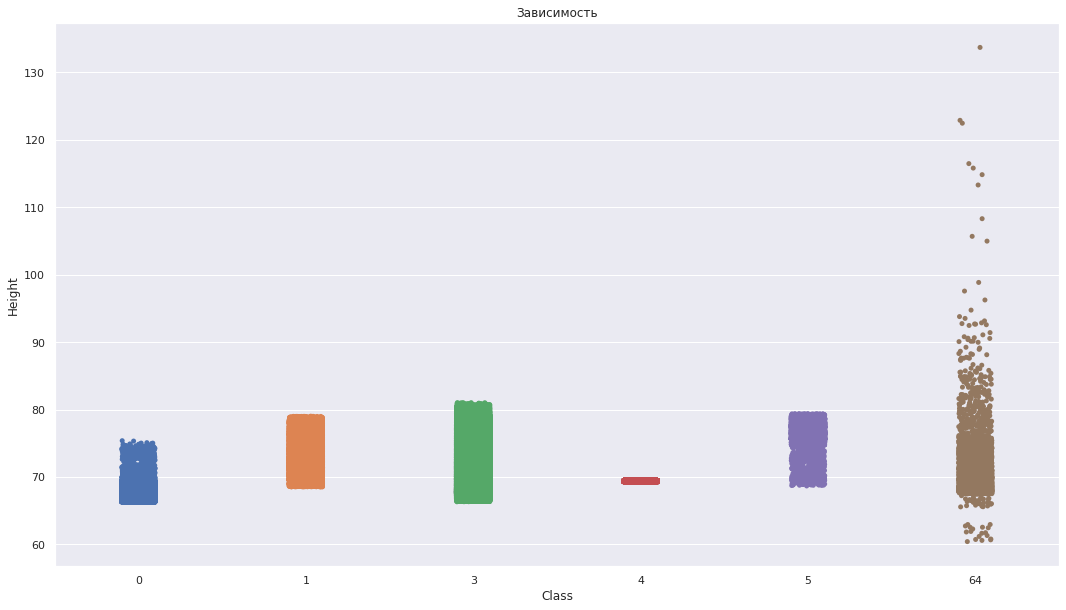

In [ ]:
sns.set(rc={'figure.figsize':(18,10)})
sns.stripplot(data = train, x= "Class", y = "Height").set_title('Зависимость');

In [ ]:
height_4th_class_0 = [0]*(len(train.Easting)+1)
height_4th_class_0_test = [0]*(len(X_test.Easting)+1)

In [ ]:
i = 0
for height in train.Height:
  if 69.2493 < height < 69.5775:
    height_4th_class_0[i] = 1
  else:
    height_4th_class_0[i] = 0
  i = i+1 
height_4th_class_0.pop()
i = 0
for height in X_test.Height:
  if 69.2493 < height < 69.5775:
    height_4th_class_0_test[i] = 1
  else:
    height_4th_class_0_test[i] = 0
  i = i+1 
height_4th_class_0_test.pop()

0

In [ ]:
height_0th_class_0 = [0]*(len(train.Easting)+1)
height_0th_class_0_test = [0]*(len(X_test.Easting)+1)

In [ ]:
i = 0
for height in train.Height:
  if height < 20:
    height_0th_class_0[i] = 1
  else:
    height_0th_class_0[i] = 0
  i = i+1 
height_0th_class_0.pop()
i = 0
for height in X_test.Height:
  if height < 20:
    height_0th_class_0_test[i] = 1
  else:
    height_0th_class_0_test[i] = 0
  i = i+1 
height_0th_class_0_test.pop()

0

In [ ]:
reflectance_4th_class_0 = [0]*(len(train.Easting)+1)
reflectance_4th_class_0_test = [0]*(len(X_test.Easting)+1)

In [ ]:
i=0
for refl in train.Reflectance:
  if refl > 0:
    reflectance_4th_class_0[i] = 1
  else:
    reflectance_4th_class_0[i] = 0
  i=i+1
reflectance_4th_class_0.pop()

0

In [ ]:
i=0
for refl in X_test.Reflectance:
  if refl > 0:
    reflectance_4th_class_0_test[i] = 1
  else:
    reflectance_4th_class_0_test[i] = 0
  i = i+1
reflectance_4th_class_0_test.pop()

0

In [ ]:
reflectance_for5 = [0]*(len(train.Easting)+1)
reflectance_for5_test = [0]*(len(X_test.Easting)+1)

In [ ]:
i=0
for refl in train.Reflectance:
  if refl < -30:
    reflectance_for5[i] = 1
  else:
    reflectance_for5[i] = 0
  i=i+1
reflectance_for5.pop()
i=0
for refl in X_test.Reflectance:
  if refl < -30:
    reflectance_for5_test[i] = 1
  else:
    reflectance_for5_test[i] = 0
  i = i+1
reflectance_for5_test.pop()

0

In [ ]:
reflectance_2030 = [0]*(len(train.Easting)+1)
reflectance_2030_test = [0]*(len(X_test.Easting)+1)

In [ ]:
i=0
for refl in train.Reflectance:
  if -30 <= refl < -20:
    reflectance_2030[i] = 1
  else:
    reflectance_2030[i] = 0
  i=i+1
reflectance_2030.pop()

0

In [ ]:
i=0
for refl in X_test.Reflectance:
  if -30 <= refl < -20:
    reflectance_2030_test[i] = 1
  else:
    reflectance_2030_test[i] = 0
  i = i+1
reflectance_2030_test.pop()

0

In [ ]:
reflectance_2010 = [0]*(len(train.Easting)+1)
reflectance_2010_test = [0]*(len(X_test.Easting)+1)

In [ ]:
i=0
for refl in train.Reflectance:
  if -20 <= refl < -10:
    reflectance_2010[i] = 1
  else:
    reflectance_2010[i] = 0
  i=i+1
reflectance_2010.pop()

0

In [ ]:
i=0
for refl in X_test.Reflectance:
  if -20 <= refl < -10:
    reflectance_2010_test[i] = 1
  else:
    reflectance_2010_test[i] = 0
  i = i+1
reflectance_2010_test.pop()

0

In [ ]:
reflectance_100 = [0]*(len(train.Easting)+1)
reflectance_100_test = [0]*(len(X_test.Easting)+1)

In [ ]:
i=0
for refl in train.Reflectance:
  if -10 <= refl <= 0:
    reflectance_100[i] = 1
  else:
    reflectance_100[i] = 0
  i=i+1
reflectance_100.pop()

0

In [ ]:
i=0
for refl in X_test.Reflectance:
  if -10 <= refl < -0:
    reflectance_100_test[i] = 1
  else:
    reflectance_100_test[i] = 0
  i = i+1
reflectance_100_test.pop()

0

In [ ]:
len(height_4th_class_0)

4222094

In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
feats_north = pd.DataFrame(columns = ['northing_4th_class_0', 'northing_4th_class_1', 'northing_4th_class_2', 'northing_4th_class_3', 'northing_4th_class_4', 'northing_4th_class_5', 'northing_4th_class_6'])
feats_east = pd.DataFrame(columns = [ 'easting_4th_class_0',
                        'easting_4th_class_1', 'easting_4th_class_2', 'easting_4th_class_3', 'easting_4th_class_4', 'easting_4th_class_5', 'easting_4th_class_6', 'height_4th_class_0','height_0th_class_0', 'reflectance_4th_class_0', 'reflectance_for5', 'reflectance_2030', 'reflectance_2010', 'reflectance_100'])


In [ ]:
feats_north_test = pd.DataFrame(columns = ['northing_4th_class_0', 'northing_4th_class_1', 'northing_4th_class_2', 'northing_4th_class_3', 'northing_4th_class_4', 'northing_4th_class_5', 'northing_4th_class_6'])
feats_east_test = pd.DataFrame(columns = [ 'easting_4th_class_0',
                        'easting_4th_class_1', 'easting_4th_class_2', 'easting_4th_class_3', 'easting_4th_class_4', 'easting_4th_class_5', 'easting_4th_class_6', 'height_4th_class_0','height_0th_class_0', 'reflectance_4th_class_0', 'reflectance_for5', 'reflectance_2030', 'reflectance_2010', 'reflectance_100'])

In [ ]:
feats_north['northing_4th_class_0'] = northing_4th_class_0
feats_north['northing_4th_class_1'] = northing_4th_class_1
feats_north['northing_4th_class_2'] = northing_4th_class_2
feats_north['northing_4th_class_3'] = northing_4th_class_3
feats_north['northing_4th_class_4'] = northing_4th_class_4
feats_north['northing_4th_class_5'] = northing_4th_class_5
feats_north['northing_4th_class_6'] = northing_4th_class_6
feats_east['easting_4th_class_0'] = easting_4th_class_0
feats_east['easting_4th_class_1'] = easting_4th_class_1
feats_east['easting_4th_class_2'] = easting_4th_class_2
feats_east['easting_4th_class_3'] = easting_4th_class_3
feats_east['easting_4th_class_4'] = easting_4th_class_4
feats_east['easting_4th_class_5'] = easting_4th_class_5
feats_east['easting_4th_class_6'] = easting_4th_class_6
feats_east['height_4th_class_0'] = height_4th_class_0
feats_east['reflectance_4th_class_0'] = reflectance_4th_class_0
feats_east['reflectance_for5'] = reflectance_for5
feats_east['height_0th_class_0'] = height_0th_class_0
feats_east['reflectance_2030'] = reflectance_2030
feats_east['reflectance_2010'] = reflectance_2010
feats_east['reflectance_100'] = reflectance_100

In [ ]:
feats_north_test['northing_4th_class_0'] = northing_4th_class_0_test
feats_north_test['northing_4th_class_1'] = northing_4th_class_1_test
feats_north_test['northing_4th_class_2'] = northing_4th_class_2_test
feats_north_test['northing_4th_class_3'] = northing_4th_class_3_test
feats_north_test['northing_4th_class_4'] = northing_4th_class_4_test
feats_north_test['northing_4th_class_5'] = northing_4th_class_5_test
feats_north_test['northing_4th_class_6'] = northing_4th_class_6_test
feats_east_test['easting_4th_class_0'] = easting_4th_class_0_test
feats_east_test['easting_4th_class_1'] = easting_4th_class_1_test
feats_east_test['easting_4th_class_2'] = easting_4th_class_2_test
feats_east_test['easting_4th_class_3'] = easting_4th_class_3_test
feats_east_test['easting_4th_class_4'] = easting_4th_class_4_test
feats_east_test['easting_4th_class_5'] = easting_4th_class_5_test
feats_east_test['easting_4th_class_6'] = easting_4th_class_6_test
feats_east_test['height_4th_class_0'] = height_4th_class_0_test
feats_east_test['reflectance_4th_class_0'] = reflectance_4th_class_0_test
feats_east_test['reflectance_for5'] = reflectance_for5_test
feats_east_test['height_0th_class_0'] = height_0th_class_0_test
feats_east_test['reflectance_2030'] = reflectance_2030_test
feats_east_test['reflectance_2010'] = reflectance_2010_test
feats_east_test['reflectance_100'] = reflectance_100_test

In [ ]:
frames = [train, feats_north, feats_east]
frames_test = [X_test, feats_north_test, feats_east_test]
train_fin = pd.concat(frames, axis=1)
X_test_fin = pd.concat(frames_test, axis=1)
train_fin = train_fin.fillna(0)
X_test_fin = X_test_fin.fillna(0)

In [ ]:
X_test.columns

Index(['id', 'Easting', 'Northing', 'Height', 'Reflectance'], dtype='object')

# Data preparation and cross validation

In [ ]:
X_train = train_fin.drop(['id', 'Class'], axis = 1)
X_test_id = X_test['id'] 
y_train_fin = train_fin['Class']
X_test = X_test_fin.drop('id' ,axis= 1)

In [ ]:
X_train = X_train.drop(['Reflectance'], axis = 1)
X_test = X_test.drop(['Reflectance'], axis = 1)

In [ ]:
from sklearn.model_selection import train_test_split

x_train, x_cv, y_train, y_cv = train_test_split(X_train,y_train_fin,test_size = 0.2,train_size =0.8, random_state=42)

In [ ]:
from sklearn.tree import DecisionTreeClassifier


In [ ]:
dec_tree2 = DecisionTreeClassifier(criterion='entropy' , max_depth = 30)

In [ ]:
dec_tree2.fit(x_train, y_train)

DecisionTreeClassifier()

In [ ]:
predictions_cv = dec_tree2.predict(x_cv)

In [ ]:
X_test.shape

(1809469, 24)

In [ ]:
result = recall_score(y_cv, predictions_cv, average='macro', zero_division=True)
print("Recall score",result)

Recall score 0.9291278885972308


# Best parameters evaluation

In [ ]:
criterion = ['gini', 'entropy'] 
max_depth = [4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150]

In [ ]:
parameters = dict(criterion=criterion,
                     max_depth=max_depth)

In [ ]:
dec_tree3  = DecisionTreeClassifier(criterion = 'entropy')

In [ ]:
model = GridSearchCV(dec_tree3, param_grid = parameters, cv=5, verbose = 4)


In [ ]:
search = model.fit(x_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5] END .......criterion=gini, max_depth=4;, score=0.855 total time=  13.0s
[CV 2/5] END .......criterion=gini, max_depth=4;, score=0.854 total time=  11.4s
[CV 3/5] END .......criterion=gini, max_depth=4;, score=0.855 total time=  11.4s
[CV 4/5] END .......criterion=gini, max_depth=4;, score=0.855 total time=  11.4s
[CV 5/5] END .......criterion=gini, max_depth=4;, score=0.854 total time=  12.0s
[CV 1/5] END .......criterion=gini, max_depth=5;, score=0.876 total time=  13.8s
[CV 2/5] END .......criterion=gini, max_depth=5;, score=0.875 total time=  13.6s
[CV 3/5] END .......criterion=gini, max_depth=5;, score=0.871 total time=  13.7s
[CV 4/5] END .......criterion=gini, max_depth=5;, score=0.875 total time=  13.9s
[CV 5/5] END .......criterion=gini, max_depth=5;, score=0.875 total time=  13.7s
[CV 1/5] END .......criterion=gini, max_depth=6;, score=0.881 total time=  16.4s
[CV 2/5] END .......criterion=gini, max_depth=6

In [ ]:
search.best_params_

{'criterion': 'entropy', 'max_depth': 30}

# Solution output

In [ ]:
results_final = dec_tree2.predict(X_test)

In [ ]:
results_final = list(results_final)

In [ ]:
results_final = [int(x) for x in results_final]

In [ ]:
df1_fin = pd.DataFrame(columns = ['id', 'Class'])

In [ ]:
df1_fin['id'] = X_test_id

In [ ]:
df1_fin['Class'] = results_final


In [ ]:
df1_fin.to_csv('decsampled.csv', sep=',', index=False)